Uncomment this part to install the required packages

In [1]:
# !pip install jax
# !pip instal numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install transforms3d

In [2]:

import jax
import pickle
import os

import transforms3d as t3d
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3

from tqdm import tqdm

eps = 1e-6
g = 9.81

print(os.getcwd())

/Users/pedramaghazadeh/Desktop/ECE276A_PR1


In [3]:
dataset = 10
path = "."

In [4]:
def rotplot(R, currentAxes=None):
	# Plots the orientation of a 3x3 rotation matrix R.
	# You should modify it as you wish for the project.

	lx = 3.0
	ly = 1.5
	lz = 1.0

	x = .5*np.array([[+lx, -lx, +lx, -lx, +lx, -lx, +lx, -lx],
		[+ly, +ly, -ly, -ly, +ly, +ly, -ly, -ly],
		[+lz, +lz, +lz, +lz, -lz, -lz, -lz, -lz]])

	xp = np.dot(R,x);
	ifront = np.array([0, 2, 6, 4, 0])
	iback = np.array([1, 3, 7, 5, 1])
	itop = np.array([0, 1, 3, 2, 0])
	ibottom = np.array([4, 5, 7, 6, 4])
	
	if currentAxes is not None:
		ax = currentAxes
	else:
		fig = plt.figure()
		ax = fig.add_subplot(projection = '3d')

	ax.plot(xp[0,itop], xp[1,itop], xp[2,itop], 'k-')
	ax.plot(xp[0,ibottom], xp[1,ibottom], xp[2,ibottom], 'k-')
	
	rectangleFront = a3.art3d.Poly3DCollection([list(zip(xp[0,ifront], xp[1,ifront],xp[2,ifront]))])
	rectangleFront.set_facecolor('Blue')
	ax.add_collection(rectangleFront)
	
	rectangleBack = a3.art3d.Poly3DCollection([list(zip(xp[0,iback], xp[1,iback],xp[2,iback]))])
	rectangleBack.set_facecolor('Red')
	ax.add_collection(rectangleBack)

	ax.set_xlim3d(-2, 2)
	ax.set_ylim3d(-2, 2)
	ax.set_zlim3d(-2, 2)
	
	return ax

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

In [5]:
ifile = f"{path}/data/imu/imuRaw{dataset}.p"
vfile = f"{path}/data/vicon/viconRot{dataset}.p"

imud = read_data(ifile)
print(f"Shape of imu data {imud.shape}")

if dataset < 10:
    vicd = read_data(vfile)
    print(f"Keys of vicon data {vicd.keys()}")


imu_ts, imu_ax, imu_ay, imu_az, imu_wx, imu_wy, imu_wz = imud

Shape of imu data (7, 3078)


In [6]:
if dataset < 10:
    print(f"Raw shape of rots {vicd["rots"].shape} and ts {vicd["ts"].shape}")
    vicd["rots"] = vicd["rots"].transpose(2, 0, 1)
    vicd["ts"] = vicd["ts"].transpose(1, 0).reshape(-1)
    vicd["ts"] = vicd["ts"] - vicd["ts"][0]

imu_ts = imu_ts - imu_ts[0]

In [7]:
# This statinoary value didn't work well
# stationary_ts = abs(len(imud[0]) - len(vicd["ts"]))
# print(f"Stationary ts is {stationary_ts}")

# Neither did this one
# if len(imud[0]) > len(vicd["ts"]):
#     min_delta = np.sum(np.abs(vicd["ts"] - imu_ts[0: - stationary_ts]))
# else:
#     min_delta = np.sum(np.abs(vicd["ts"][0: - stationary_ts] - imu_ts))
# sync_ind = 0
# for i in range(stationary_ts):
#     delta = np.sum(np.abs(vicd["ts"] - imu_ts[i: - stationary_ts + i]))
#     if delta < min_delta:
#         min_delta = delta
#         sync_ind = i
# print(f"Sync index is {sync_ind}")

# This one works well
stationary_ts = 400

In [8]:
SENSITIVITY_ACC = 300
SENSITIVITY_GYRO = 3.33 * 180 / np.pi

acc_scale_factor = 3300 / 1023 / SENSITIVITY_ACC
accx_bias = np.mean(imu_ax[:stationary_ts])
accy_bias = np.mean(imu_ay[:stationary_ts])
accz_bias = np.mean(imu_az[:stationary_ts]) - 1 / acc_scale_factor

print(f"Acc bias is {accx_bias}, {accy_bias}, {accz_bias} and the scale factor is {acc_scale_factor}")

gyro_scale_factor = 3300 / 1023 / SENSITIVITY_GYRO
gyrox_bias = np.mean(imu_wx[:stationary_ts])
gyroy_bias = np.mean(imu_wy[:stationary_ts])
gyroz_bias = np.mean(imu_wz[:stationary_ts])

print(f"Gyro bias is {gyrox_bias}, {gyroy_bias}, {gyroz_bias} and the scale factor is {gyro_scale_factor}")

Acc bias is -511.03, -501.0, 513.0175 and the scale factor is 0.01075268817204301
Gyro bias is 373.585, 375.4175, 369.6325 and the scale factor is 0.01690719027409018


<Figure size 640x480 with 0 Axes>

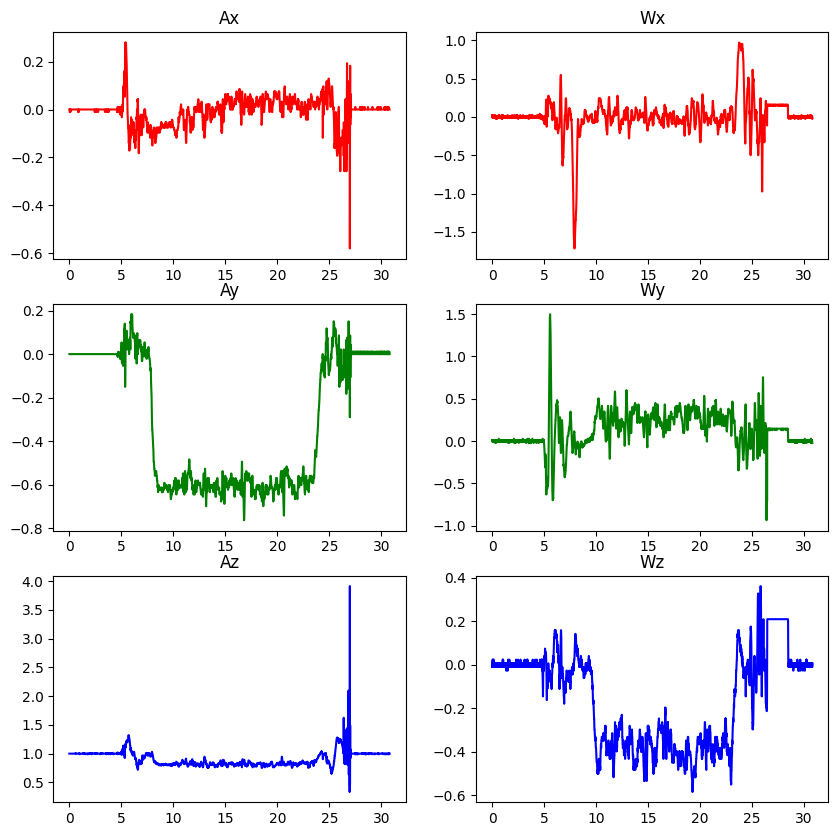

In [9]:
imu_ax = (imu_ax - accx_bias) * acc_scale_factor
imu_ay = (imu_ay - accy_bias) * acc_scale_factor
imu_az = (imu_az - accz_bias) * acc_scale_factor

imu_wx = (imu_wx - gyrox_bias) * gyro_scale_factor
imu_wy = (imu_wy - gyroy_bias) * gyro_scale_factor
imu_wz = (imu_wz - gyroz_bias) * gyro_scale_factor

imu_wx = np.clip(imu_wx, -np.pi, np.pi)
imu_wy = np.clip(imu_wy, -np.pi, np.pi)
imu_wz = np.clip(imu_wz, -np.pi, np.pi)
# for i in range(len(imu_ts)):
#     if imu_wx[i] == 0:
#         imu_wx[i] = eps
#     if imu_wy[i] == 0:
#         imu_wy[i] = eps
#     if imu_wz[i] == 0:
#         imu_wz[i] = eps

# Plotting the ax, ay, az on three different subplots
plt.tight_layout()
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(imu_ts, imu_ax, color='r')
plt.title("Ax")
plt.subplot(3, 2, 3)
plt.plot(imu_ts, imu_ay, color='g')
plt.title("Ay")
plt.subplot(3, 2, 5)
plt.plot(imu_ts, imu_az, color='b')
plt.title("Az")

# Plotting the wx, wy, wz on three different subplots
plt.subplot(3, 2, 2)
plt.plot(imu_ts, imu_wx, color='r')
plt.title("Wx")
plt.subplot(3, 2, 4)
plt.plot(imu_ts, imu_wy, color='g')
plt.title("Wy")
plt.subplot(3, 2, 6)
plt.plot(imu_ts, imu_wz, color='b')
plt.title("Wz")

plt.show()

In [10]:
def compute_angles(quaternions):
    pred_roll = []
    pred_pitch = []
    pred_yaw = []

    for i in range(len(quaternions)):
        r, p, y = t3d.euler.quat2euler(quaternions[i], axes='sxyz')
        pred_roll.append(r)
        pred_pitch.append(p)
        pred_yaw.append(y)

    integrated_roll = []
    integrated_pitch = []
    integrated_yaw = []
    
    q = jnp.array([1.0, 0.0, 0.0, 0.0])
    r, p, y = t3d.euler.quat2euler(q, axes='sxyz')
    integrated_roll.append(r)
    integrated_pitch.append(p)
    integrated_yaw.append(y)

    for i in range(1, len(quaternions)):
        q = motion_model_v(quaternions[i - 1: i], imu_vector[i - 1: i], imu_timestamps[i - 1: i])
        q = q / jnp.linalg.norm(q)
        r, p, y = t3d.euler.quat2euler(q[0], axes='sxyz')
        integrated_roll.append(r )
        integrated_pitch.append(p)
        integrated_yaw.append(y)
    

    # return pred_roll, pred_pitch, pred_yaw
    return pred_roll, pred_pitch, pred_yaw, integrated_roll, integrated_pitch, integrated_yaw

def compute_accs(q_traj):
    acc = quat_vmult(quat_vinv(q_traj), quat_vmult(gravity[None, :], q_traj))
    
    pred_ax = acc[:, 1]
    pred_ay = acc[:, 2]
    pred_az = acc[:, 3]

    return pred_ax, pred_ay, pred_az


In [11]:
roll = []
pitch = []
yaw = []

if dataset < 10:
    for i in range(len(vicd["rots"])):
        r, p, y = t3d.euler.mat2euler(vicd["rots"][i], axes='sxyz')
        roll.append(r)
        pitch.append(p)
        yaw.append(y)

    # Plotting the Roll, Pitch, and Yaw on three different subplots
    plt.tight_layout()
    plt.figure(figsize=(5, 6))
    plt.subplot(3, 1, 1)
    plt.plot(vicd["ts"], roll, color='r')
    plt.title("GT Roll")
    plt.subplot(3, 1, 2)
    plt.plot(vicd["ts"], pitch, color='g')
    plt.title("GT Pitch")
    plt.subplot(3, 1, 3)
    plt.plot(vicd["ts"], yaw, color='b')
    plt.title("GT Yaw")
    plt.show()

In [12]:
if dataset < 10:
    axis = rotplot(vicd["rots"][0])
    for i in range(1, len(vicd["rots"]), 450):
        axis = rotplot(vicd["rots"][i], axis)

    plt.show()

In [13]:
def plot_angles(pred_roll, pred_pitch, pred_yaw):
    if dataset < 10:
        plt.tight_layout()
        plt.figure(figsize=(9, 9))
        plt.subplot(3, 1, 1)

        plt.plot(imu_ts, pred_roll, color='b')
        plt.plot(vicd["ts"][stationary_ts:], roll[stationary_ts:], color='r', linestyle='dashed')
        plt.legend(["Pred", "GT"])
        plt.title("Roll GT vs. Pred")
        plt.subplot(3, 1, 2)

        plt.plot(imu_ts, pred_pitch, color='b')
        plt.plot(vicd["ts"][stationary_ts:], pitch[stationary_ts:], color='r', linestyle='dashed')
        plt.legend(["Pred", "GT"])
        plt.title("Pitch GT vs. Pred")

        plt.subplot(3, 1, 3)
        plt.plot(imu_ts, pred_yaw, color='b')
        plt.plot(vicd["ts"][stationary_ts:], yaw[stationary_ts:], color='r', linestyle='dashed')
        plt.legend(["Pred", "GT"])
        plt.title("Yaw GT vs. Pred")
        plt.show()
    else:
        plt.tight_layout()
        plt.figure(figsize=(9, 9))
        plt.subplot(3, 1, 1)

        plt.plot(imu_ts, pred_roll, color='b')
        plt.legend(["Pred"])
        plt.title("Roll Pred")
        plt.subplot(3, 1, 2)

        plt.plot(imu_ts, pred_pitch, color='b')
        plt.legend(["Pred"])
        plt.title("Pitch Pred")

        plt.subplot(3, 1, 3)
        plt.plot(imu_ts, pred_yaw, color='b')
        plt.legend(["Pred"])
        plt.title("Yaw Pred")
        plt.show()

def plot_angles_all(pred_roll, pred_pitch, pred_yaw, integreated_roll, integreated_pitch, integreated_yaw):
    if dataset < 10:
        plt.tight_layout()
        plt.figure(figsize=(9, 9))
        plt.subplot(3, 1, 1)

        plt.plot(imu_ts, pred_roll, color='b')
        plt.plot(imu_ts, integreated_roll, color='g', linestyle='dotted')
        plt.plot(vicd["ts"][stationary_ts:], roll[stationary_ts:], color='r', linestyle='dashed')
        plt.legend(["Pred", "Integrated", "GT"])
        plt.title("Roll GT vs. Integrated vs. Pred")
        plt.subplot(3, 1, 2)

        plt.plot(imu_ts, pred_pitch, color='b')
        plt.plot(imu_ts, integreated_pitch, color='g', linestyle='dotted')
        plt.plot(vicd["ts"][stationary_ts:], pitch[stationary_ts:], color='r', linestyle='dashed')
        plt.legend(["Pred", "Integrated", "GT"])
        plt.title("Pitch GT vs. Integrated vs. Pred")

        plt.subplot(3, 1, 3)
        plt.plot(imu_ts, pred_yaw, color='b')
        plt.plot(imu_ts, integreated_yaw, color='g', linestyle='dotted')
        plt.plot(vicd["ts"][stationary_ts:], yaw[stationary_ts:], color='r', linestyle='dashed')
        plt.legend(["Pred", "Integrated", "GT"])
        plt.title("Yaw GT vs. Integrated vs. Pred")

    else:
        plt.tight_layout()
        plt.figure(figsize=(9, 9))
        plt.subplot(3, 1, 1)

        plt.plot(imu_ts, pred_roll, color='b')
        plt.plot(imu_ts, integreated_roll, color='r')
        plt.legend(["Pred", "Integrated"])
        plt.title("Roll Pred vs. Integrated")
        plt.subplot(3, 1, 2)

        plt.plot(imu_ts, pred_pitch, color='b')
        plt.plot(imu_ts, integreated_pitch, color='r')
        plt.legend(["Pred", "Integrated"])
        plt.title("Pitch Pred vs. Integrated")

        plt.subplot(3, 1, 3)
        plt.plot(imu_ts, pred_yaw, color='b')
        plt.plot(imu_ts, integreated_yaw, color='r')
        plt.legend(["Pred", "Integrated"])
        plt.title("Yaw Pred vs. Integrated")
        
    plt.savefig(f"./figures/angles_{dataset}.png")
    plt.show()

def plot_accs(pred_ax, pred_ay, pred_az, grav=1):
    plt.tight_layout()
    plt.figure(figsize=(9, 9))
    plt.subplot(3, 1, 1)

    plt.plot(imu_ts, pred_ax, color='b')
    plt.plot(imu_ts, imu_ax * grav, color='r', linestyle='dashed')
    plt.legend(["Pred", "GT"])
    plt.title("Acceleration X GT vs. Pred")
    plt.subplot(3, 1, 2)

    plt.plot(imu_ts, pred_ay, color='b')
    plt.plot(imu_ts, imu_ay * grav, color='r', linestyle='dashed')
    plt.legend(["Pred", "GT"])
    plt.title("Acceleration Y GT vs. Pred")

    plt.subplot(3, 1, 3)
    plt.plot(imu_ts, pred_az, color='b')
    plt.plot(imu_ts, imu_az * grav, color='r', linestyle='dashed')
    plt.legend(["Pred", "GT"])
    plt.title("Acceleration z GT vs. Pred")
    
    plt.savefig(f"./figures/accelerations_{dataset}.png")
    plt.show()

In [14]:
imu_vector = jnp.vstack([jnp.zeros((len(imu_ax))), imu_wx, imu_wy, imu_wz]).transpose()
imu_acc = jnp.vstack([jnp.zeros((len(imu_ax))), imu_ax[:], imu_ay[:], imu_az[:]]).transpose()
imu_timestamps = jnp.vstack([imu_ts[1:] - imu_ts[:-1], imu_ts[1:] - imu_ts[:-1], imu_ts[1:] - imu_ts[:-1], imu_ts[1:] - imu_ts[:-1]]).transpose()
# imu_timestamps = jnp.vstack([jnp.zeros((len(imu_ax))), imu_wx, imu_wy, imu_wz]).transpose()

print((imu_vector * imu_timestamps[:, None]).shape, imu_vector.shape, imu_acc.shape, imu_timestamps.shape)

(3077, 3078, 4) (3078, 4) (3078, 4) (3077, 4)


In [15]:
# To multiply a vector by a vector of scalars, use [:, None] to add a new dimension
@jax.jit
def quat_vmult(q1, q2):
    """
    Vectorized Quaternion multiplication
    inputs:
    q1: [s, v] quaternion
    q2: [s, v] quaternion
    output:
    q1 * q2: [s, v] quaternion
    """
    q1_s, q1_v = q1[:, 0], q1[:, 1:]
    q2_s, q2_v = q2[:, 0], q2[:, 1:]
    s = q1_s * q2_s - jnp.sum(q1_v * q2_v, axis=1)
    v = q1_s[:, None] * q2_v + q2_s[:, None] * q1_v + jnp.cross(q1_v, q2_v, axis=1)
    return jnp.hstack([s[:, None], v])

@jax.jit
def quat_vexp(q):
    """"
    Vectorized Quaternion exponential
    inputs:
    q: [s, v] quaternion
    output:
    exp(q): [s, v] quaternion
    """
    q_s, q_v = q[:, 0], q[:, 1:]
    theta = jnp.linalg.norm(q_v, axis=1)
    safe_theta = jnp.where(theta < eps, eps, theta)
    q = jnp.hstack([jnp.cos(theta)[:, None], q_v * (jnp.sin(theta) / safe_theta)[:, None] ])
    return jnp.exp(q_s)[:, None] * q

@jax.jit
def quat_vlog(q):
    """"
    Vectorized Quaternion logarithm
    inputs:
    q: [n, s, v] n quaternions
    output:
    log(q): [n, s, v] n quaternions
    """
    q_s, q_v = q[:, 0], q[:, 1:]

    norm = jnp.linalg.norm(q + eps, axis=1)
    log_norm = jnp.log(norm) + eps
    acos_input = q_s / norm
    return jnp.hstack([log_norm[:, None], q_v / (norm[:, None] + eps) * jnp.arccos(acos_input)[:, None]])

@jax.jit
def motion_model_v(q, imu, dt):
    """
    Vectorized Motion model calculation from IMU rotation rates
    inputs:
    q: [s, v] quaternion
    imu_wx: x-axis rotation rate
    imu_wy: y-axis rotation rate
    imu_wz: z-axis rotation rate
    dt: time stamp
    output:
    estimated q: [s, v] quaternion
    """
    quat = imu * dt / 2
    x = quat_vmult(q, quat_vexp(quat))
    return x 

@jax.jit
def cost_function_v(q_traj, imu_vector, imu_timestamps):
    """
    Cost function for the optimization problem
    inputs:
    q_traj: [n, 4] trajectory of quaternions
    output:
    cost: scalar cost value: sum of the motion and observation model errors
    """
    errors = 0
    # Motion model
    q_estimated = motion_model_v(q_traj[:-1], imu_vector[:-1], imu_timestamps)
    # error = quat_vlog(quat_vmult(quat_vinv(q_traj[1:]), q_estimated)) * 2

    error = quat_vlog(quat_vmult(quat_vinv(q_traj[1:]), q_estimated)) * 2
    errors += jnp.sum(jnp.linalg.norm(error) ** 2)

    # # Observation model
    acc = quat_vmult(quat_vmult(quat_vinv(q_traj[1:]), gravity[None, :]), q_traj[1:])
    gt = imu_acc[1:]
    errors += jnp.sum(jnp.linalg.norm(gt - acc, axis=1) ** 2)

    return errors / 2

@jax.jit
def quat_vinv(q):
    """"
    Vectorized Quaternion inverse
    inputs:
    q: [n, s, v] n quaternions
    output:
    log(q): [n, s, v] n quaternions
    """
    norm_q = jnp.linalg.norm(q, axis=1) ** 2 + eps
    q = q * jnp.array([1.0, -1.0, -1.0, -1.0])
    return q / norm_q[:, None]

Optimization step

In [ ]:
gravity = jnp.array([0, 0, 0, 1], dtype=jnp.float32)
alpha = 0.01
q_0 = jnp.array([1, 0, 0, 0], dtype=jnp.float32)
grad_cost = jax.grad(cost_function_v)

q_traj = jnp.zeros((len(imu_ax), 4))
q_traj = q_traj.at[0].set(q_0)
q = q_0

for i in range(1, len(q_traj)):
    q = motion_model_v(q_traj[i - 1: i], imu_vector[i - 1: i], imu_timestamps[i - 1: i])
    q_traj = q_traj.at[i].set(q[0])

costs = []

for i in tqdm(range(2_000)):
    costs.append(cost_function_v(q_traj, imu_vector, imu_timestamps))
    if i % 100 == 0:
        print(f"Cost at iteration {i} is {costs[-1]}")
    q_traj = q_traj - alpha * grad_cost(q_traj, imu_vector, imu_timestamps)
    q_traj = q_traj / jnp.linalg.norm(q_traj, axis=1, keepdims=True)

plot_angles_all(*compute_angles(q_traj))
plot_accs(*compute_accs(q_traj))
plt.title("Costs")
plt.plot(costs)

Non-vectorized version of functions

In [17]:
# gravity = jnp.array([0, 0, 0, 1], dtype=jnp.float32)

# def quat_mult(q1, q2):
#     """
#     Quaternion multiplication
#     inputs:
#     q1: [s, v] quaternion
#     q2: [s, v] quaternion
#     output:
#     q1 * q2: [s, v] quaternion
#     """
#     q1_s, q1_v = q1[0], q1[1:]
#     q2_s, q2_v = q2[0], q2[1:]
#     s = q1_s * q2_s - jnp.dot(q1_v, q2_v)
#     v = q1_s * q2_v + q2_s * q1_v + jnp.cross(q1_v, q2_v)
#     return jnp.array([s, v[0], v[1], v[2]])

# def quat_exp(q):
#     """"
#     Quaternion exponential
#     inputs:
#     q: [s, v] quaternion
#     output:
#     exp(q): [s, v] quaternion
#     """
#     # q_s, q_v = q[0], q[1:]
#     # return jnp.exp(q_s) * jnp.hstack(jnp.cos(jnp.linalg.norm(q_v)), q_v * jnp.sin(jnp.linalg.norm(q_v)) / jnp.linalg.norm(q_v))
#     # theta = jnp.linalg.norm(q[1:]) + eps
#     # return jnp.exp(q[0]) * jnp.concatenate([jnp.array([jnp.cos(theta)]), jnp.sin(theta) * q[1:] / theta])
#     q_s, q_v = q[0], q[1:]
#     theta = jnp.linalg.norm(q_v)
#     return jnp.exp(q_s) * jnp.concatenate([jnp.array([jnp.cos(theta)]), jnp.sin(theta) / theta * q_v ])

# def quat_log(q):
#     """"
#     Quaternion logarithm
#     inputs:
#     q: [s, v] quaternion
#     output:
#     log(q): [s, v] quaternion
#     """
#     q_s, q_v = q[0], q[1:]
#     norm = jnp.linalg.norm(q)
#     log_norm = jnp.log(norm)
#     if norm == 1 and jnp.linalg.norm(q[1:]) == 0:
#         return jnp.array([norm, 0, 0, 0])
#     acos_input = jnp.clip(q_s / norm, -1 + eps, 1 - eps)
#     return jnp.concatenate([jnp.array([log_norm]), q_v / (jnp.linalg.norm(q_v) + eps) * jnp.arccos(acos_input)])

# def quat_inv(q):
#     """"
#     Quaternion inverse
#     inputs:
#     q: [s, v] quaternion
#     output:
#     q_inv: [s, v] quaternion
#     """
#     norm_q = jnp.linalg.norm(q) ** 2
#     safe_norm = jnp.where(norm_q < eps, eps, norm_q)  # Avoid division by zero
#     return jnp.array([q[0], -q[1], -q[2], -q[3]], dtype=jnp.float32) / safe_norm

# def motion_model(q, imu_wx, imu_wy, imu_wz, dt):
#     """
#     Motion model calculation from IMU rotation rates
#     inputs:
#     q: [s, v] quaternion
#     imu_wx: x-axis rotation rate
#     imu_wy: y-axis rotation rate
#     imu_wz: z-axis rotation rate
#     dt: time step
#     output:
#     estimated q: [s, v] quaternion
#     """
#     quat = jnp.array([0, imu_wx, imu_wy, imu_wz], dtype=jnp.float32) * dt / 2
#     return quat_mult(q, quat_exp(quat))

# def cost_function(q_traj):
#     """
#     Cost function for the optimization problem
#     inputs:
#     q_traj: [n, 4] trajectory of quaternions
#     output:
#     cost: scalar cost value: sum of the motion and observation model errors
#     """
#     errors = 0
#     for i in range(1, len(q_traj)):
#         # Motion model
#         q_estimated = motion_model(q_traj[i - 1], imu_wx[i - 1], imu_wy[i - 1], imu_wz[i - 1], imu_ts[i] - imu_ts[i - 1])
#         error = quat_log(quat_mult(quat_inv(q_traj[i]), q_estimated)) * 2
#         errors += jnp.linalg.norm(error) ** 2
        
#         # Observation model
#         acc = quat_mult(quat_inv(q_traj[i]), quat_mult(gravity, q_traj[i]))
#         gt = jnp.array([0, imu_ax[i], imu_ay[i], imu_az[i]], dtype=jnp.float32)
#         errors += jnp.linalg.norm(gt - acc) ** 2

#     return errors / 2

# alpha = 0.01
# q_0 = jnp.array([1, 0, 0, 0], dtype=jnp.float32)
# grad_cost = jax.grad(cost_function)

# q_traj = jnp.zeros((len(imu_ax), 4))
# q_traj = q_traj.at[0].set(q_0)

# for i in range(1, len(q_traj)):
#     # Using the motion model for initialization
#     q_traj = q_traj.at[i].set(q_0)

# # for i in tqdm(range(4)):
# #     q_traj = q_traj - alpha * grad_cost(q_traj)
# #     q_traj = q_traj / jnp.linalg.norm(q_traj, axis=1, keepdims=True)
# #     plot_results(*compute_angles(q_traj))

Generating panoramic images for the test sets

In [18]:
if int(dataset) > 9:
    cfile = f"{path}/data/cam/cam{dataset}.p"
    camd = read_data(cfile)

    ifile = f"{path}/data/imu/imuRaw{dataset}.p"
    imud = read_data(ifile)

Time stamps between imu and camera are not synced nor in the same scale. Normalizing them will help.

In [ ]:
imud_ts = imud[0] - imud[0][0]
camd_ts = camd["ts"][0] - camd["ts"][0][0]
print(len(imud_ts), len(camd["ts"][0]))
print(imud_ts[0], camd["ts"][0][0])

In [ ]:
rots = []
for i in range(len(camd["ts"][0])):
    for j in range(len(imu_ts)):
        if imu_ts[j] > camd_ts[i] or j == len(imu_ts) - 1:
            rots.append(t3d.quaternions.quat2mat(q_traj[j - 1]))
            break
print(len(rots), len(camd_ts))

In [ ]:
plt.imshow(camd["cam"][:, :, :, 100])

From here it's the exact same problem as generating the panoramic from the Viccon data

In [ ]:
def rotplot(R, currentAxes=None):
	# Plots the orientation of a 3x3 rotation matrix R.
	# You should modify it as you wish for the project.

	lx = 3.0
	ly = 1.5
	lz = 1.0

	x = .5*np.array([[+lx, -lx, +lx, -lx, +lx, -lx, +lx, -lx],
		[+ly, +ly, -ly, -ly, +ly, +ly, -ly, -ly],
		[+lz, +lz, +lz, +lz, -lz, -lz, -lz, -lz]])

	xp = np.dot(R,x);
	ifront = np.array([0, 2, 6, 4, 0])
	iback = np.array([1, 3, 7, 5, 1])
	itop = np.array([0, 1, 3, 2, 0])
	ibottom = np.array([4, 5, 7, 6, 4])
	
	if currentAxes is not None:
		ax = currentAxes
	else:
		fig = plt.figure()
		ax = fig.add_subplot(projection = '3d')

	ax.plot(xp[0,itop], xp[1,itop], xp[2,itop], 'k-')
	ax.plot(xp[0,ibottom], xp[1,ibottom], xp[2,ibottom], 'k-')
	
	rectangleFront = a3.art3d.Poly3DCollection([list(zip(xp[0,ifront], xp[1,ifront],xp[2,ifront]))])
	rectangleFront.set_facecolor('Blue')
	ax.add_collection(rectangleFront)
	
	rectangleBack = a3.art3d.Poly3DCollection([list(zip(xp[0,iback], xp[1,iback],xp[2,iback]))])
	rectangleBack.set_facecolor('Red')
	ax.add_collection(rectangleBack)

	ax.set_xlim3d(-2, 2)
	ax.set_ylim3d(-2, 2)
	ax.set_zlim3d(-2, 2)
	
	return ax

print(len(rots))
axis = rotplot(rots[0])
step = 1
for i in range(1, len(rots), step):
    axis = rotplot(rots[i], axis)

plt.show()

In [ ]:
height, width = 240, 320
fov_x, fov_y = 60, 45

angles_x = np.array([((90 - fov_x / 2) + (i * fov_x / width)) * (np.pi / 180) for i in range(width)])
angles_y = np.array([((90 - fov_y / 2) + (i * fov_y / height)) * (np.pi / 180) for i in range(height)])

print(angles_x.shape, angles_y.shape)

In [24]:
trigs = np.ones((height, width, 4))

for i in range(height):
    trigs[i, :, 0] = np.cos(angles_x)
    trigs[i, :, 1] = np.sin(angles_x)

for i in range(width):
    trigs[:, i, 2] = np.cos(angles_y)
    trigs[:, i, 3] = np.sin(angles_y)

In [25]:
cartesian = np.ones((height, width, 3))
cartesian[:, :, 0] = np.multiply(trigs[:, :, 3], trigs[:, :, 1])
cartesian[:, :, 1] = np.multiply(trigs[:, :, 3], trigs[:, :, 0])
cartesian[:, :, 2] = trigs[:, :, 2]

In [ ]:
panoramic_width = 1024  # Output panorama width
panoramic_height = 512  # Output panorama height

final_img = np.zeros((panoramic_height, panoramic_width, 3), dtype=np.uint8)
step = 10
rot = np.eye(3)

for i in tqdm(range(0, len(rots), step)):
    # rot = np.dot(rot, rots[i])
    rotated_cartesian = np.dot(cartesian, rots[i])
    # No need to normalize by dividing by the norms
    # norms = np.linalg.norm(rotated_cartesian, axis=2)

    # Azimuth
    theta = np.arctan2(rotated_cartesian[:, :, 1], rotated_cartesian[:, :, 0]) # theta in [-pi, pi]
    # Elevation
    phi = np.arccos(rotated_cartesian[:, :, 2]) # phi in [0, pi]

    # Normalize to the image size
    # From 2pi to panoramic_width
    u = ((theta + np.pi) / (2 * np.pi)) * panoramic_width
    # From pi to panoramic_height
    v = (phi / np.pi) * panoramic_height

    u = u.astype(np.int32)
    v = v.astype(np.int32)
    
    # print(u[0][0], v[0][0])

    for x in range(width):
        for y in range(height):
            final_img[v[y][x]][u[y][x]]= camd["cam"][y, x, :, i]
    
    # del spherical
plt.title("Panoramic image")

# if dataset > 9:
#     plt.imsave(f"panoramic_{dataset}.png", final_img)
plt.imshow(final_img)
